<a href="https://colab.research.google.com/github/Romazing/Porjestc/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing dependencies

In [34]:
# === Cell 1: Install & Mount Google Drive ===
!pip install --quiet openpyxl statsmodels

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing libraries

In [35]:
# === Cell 2: Imports & Settings ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

# Inline plotting
%matplotlib inline

# Improve plot aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


File Path

In [36]:
# === Cell 3: Load Data with Error Handling ===
file_path = '/content/drive/MyDrive/sales/sales_pattern.xlsx'

if not os.path.isfile(file_path):
    raise FileNotFoundError(f"Could not find file at {file_path}. Please check your path.")

try:
    df = pd.read_excel(file_path, engine='openpyxl')
except Exception as e:
    raise RuntimeError(f"Error reading Excel file: {e}")

# Inspect
print("Data sample:")
display(df.head())
print("\nData types:")
print(df.dtypes)


Data sample:


,Unnamed: 0,Product,2024-05-01 00:00:00,2024-05-02 00:00:00,2024-05-03 00:00:00,2024-05-06 00:00:00,2024-05-07 00:00:00,2024-05-08 00:00:00,2024-05-09 00:00:00,2024-05-10 00:00:00,...,2025-04-21 00:00:00,2025-04-22 00:00:00,2025-04-23 00:00:00,2025-04-24 00:00:00,2025-04-25 00:00:00,2025-04-28 00:00:00,2025-04-29 00:00:00,2025-04-30 00:00:00,Result.11,Period\nActuals
0,NaN,Workday number,1,2.0,3.0,3,4,5,6.0,7,...,15.0,16.0,17,18.0,19.0,20.0,21,22,Total,NaN
1,389.0,Juluca,65,NaN,NaN,14,20,50,NaN,15,...,NaN,NaN,27,NaN,NaN,NaN,100,0,567,1927.0
2,485.0,Tivicay,1400,400.0,7.0,400,950,1350,250.0,200,...,NaN,50.0,450,700.0,28.0,200.0,850,0,14760,91786.0
3,488.0,Triumeq,500,300.0,NaN,400,600,1300,100.0,100,...,NaN,70.0,350,200.0,NaN,100.0,350,0,6440,2775.0
4,1718.0,Cabenuva/Vocabria+Rekambys,76,92.0,180.0,36,61,1,2.0,11,...,100.0,72.0,12,75.0,207.0,NaN,35,80,2083,261050.0



Data types:
Unnamed: 0             float64
Product                 object
2024-05-01 00:00:00      int64
2024-05-02 00:00:00    float64
2024-05-03 00:00:00    float64
                        ...   
2025-04-28 00:00:00    float64
2025-04-29 00:00:00      int64
2025-04-30 00:00:00      int64
Result.11               object
Period\nActuals        float64
Length: 289, dtype: object


Expecting columns

In [39]:
# === Cell 4 (2nd revision): Preprocess & Pivot Robustly ===

# 1) Identify “brand” and “workday” by position
brand_col, workday_col = df.columns[0], df.columns[1]

# 2) Everything else is a date-column (could be strings or Timestamps)
date_cols = df.columns[2:]

# 3) Melt wide→long
df_long = df.melt(
    id_vars=[brand_col, workday_col],
    value_vars=date_cols,
    var_name='Date',
    value_name='Sales'
).rename(columns={brand_col: 'Brand', workday_col: 'Workday'})

# 4) Parse mixed‐type Date column
def parse_mixed_date(x):
    # if it’s already a Timestamp, keep it
    if isinstance(x, pd.Timestamp):
        return x
    # else try parsing
    return pd.to_datetime(x, dayfirst=True, errors='coerce')

df_long['Date'] = df_long['Date'].apply(parse_mixed_date)

# 5) Drop & report any rows that still failed to parse
bad_dates = df_long[df_long['Date'].isna()]
if not bad_dates.empty:
    print(f"Warning: Dropping {len(bad_dates)} rows with unparseable dates. Example values:")
    print(bad_dates[['Date']].drop_duplicates().head())
    df_long = df_long.dropna(subset=['Date'])

# 6) Final cleanup
df = df_long.sort_values('Date').reset_index(drop=True)

# Quick peek
print(df.head())
print(df.dtypes)


    Date
144  NaT
    Brand                     Workday       Date Sales
0     NaN              Workday number 2024-05-01     1
1   389.0                      Juluca 2024-05-01    65
2   485.0                     Tivicay 2024-05-01  1400
3   488.0                     Triumeq 2024-05-01   500
4  1718.0  Cabenuva/Vocabria+Rekambys 2024-05-01    76
Brand             float64
Workday            object
Date       datetime64[ns]
Sales              object
dtype: object


Time series dataframe

In [40]:
# === Cell 5: Create Time Series DataFrame ===
# Pivot so each brand is a column
ts = df.pivot_table(index='Date', columns='Brand', values='Sales', aggfunc='sum').fillna(0)

# Quick look
ts.head()


<ipython-input-40-a009eb499ae9>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ts = df.pivot_table(index='Date', columns='Brand', values='Sales', aggfunc='sum').fillna(0)


Brand,389.0,485.0,488.0,1718.0,1721.0
Date,,,,,
2024-05-01,65.0,1400.0,500.0,76.0,2450.0
2024-05-02,0.0,400.0,300.0,92.0,1100.0
2024-05-03,0.0,7.0,0.0,180.0,0.0
2024-05-06,14.0,400.0,400.0,36.0,550.0
2024-05-07,20.0,950.0,600.0,61.0,1650.0


Plotting daily time series

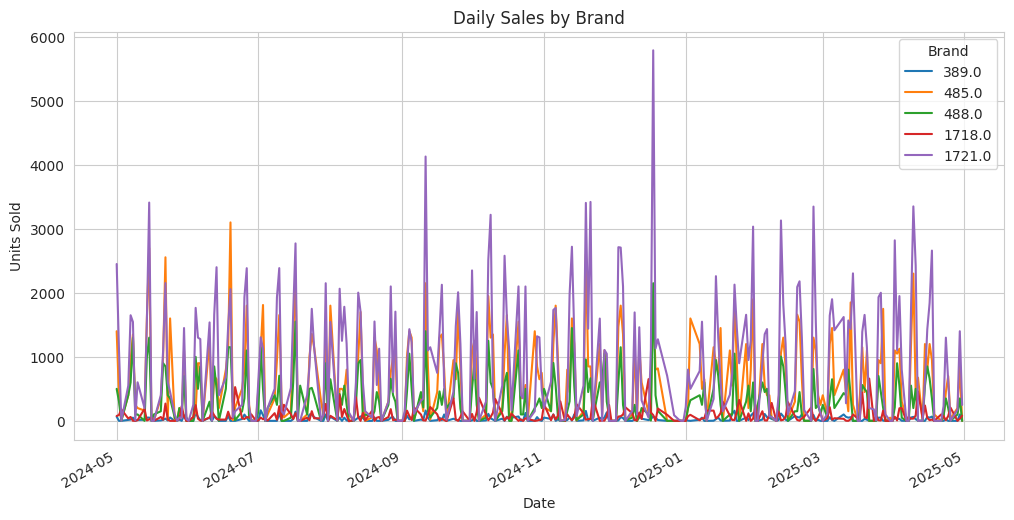

In [41]:
# === Cell 6: Plot Daily Time Series ===
ts.plot(title='Daily Sales by Brand')
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.show()


Aggregating

<ipython-input-42-ba773fad2577>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts.resample('M').sum()           # Month-end periods


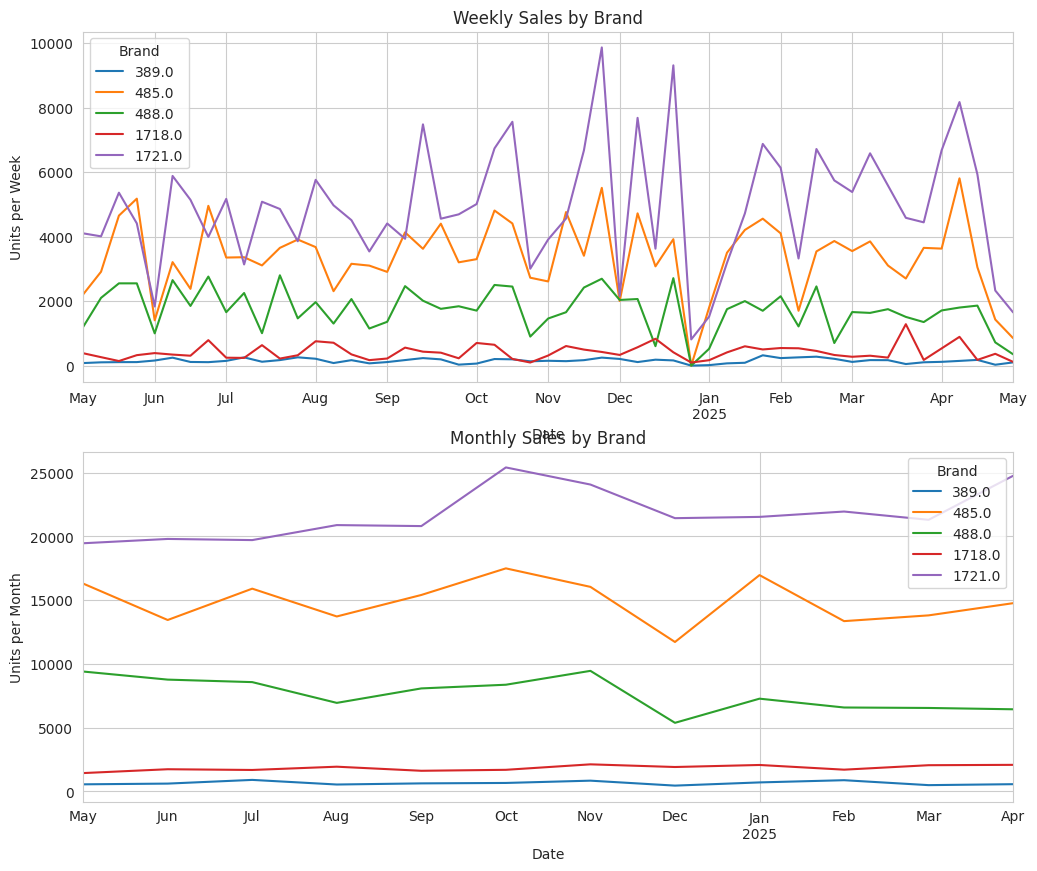

In [42]:
# === Cell 7: Aggregate & Plot Weekly and Monthly Totals ===
weekly = ts.resample('W-MON').sum()        # Weeks starting Mondays
monthly = ts.resample('M').sum()           # Month-end periods

# Plot
fig, axes = plt.subplots(2,1, figsize=(12,10), sharex=False)
weekly.plot(ax=axes[0], title='Weekly Sales by Brand')
axes[0].set_ylabel('Units per Week')
monthly.plot(ax=axes[1], title='Monthly Sales by Brand')
axes[1].set_ylabel('Units per Month')
plt.show()


Correlation Analysis

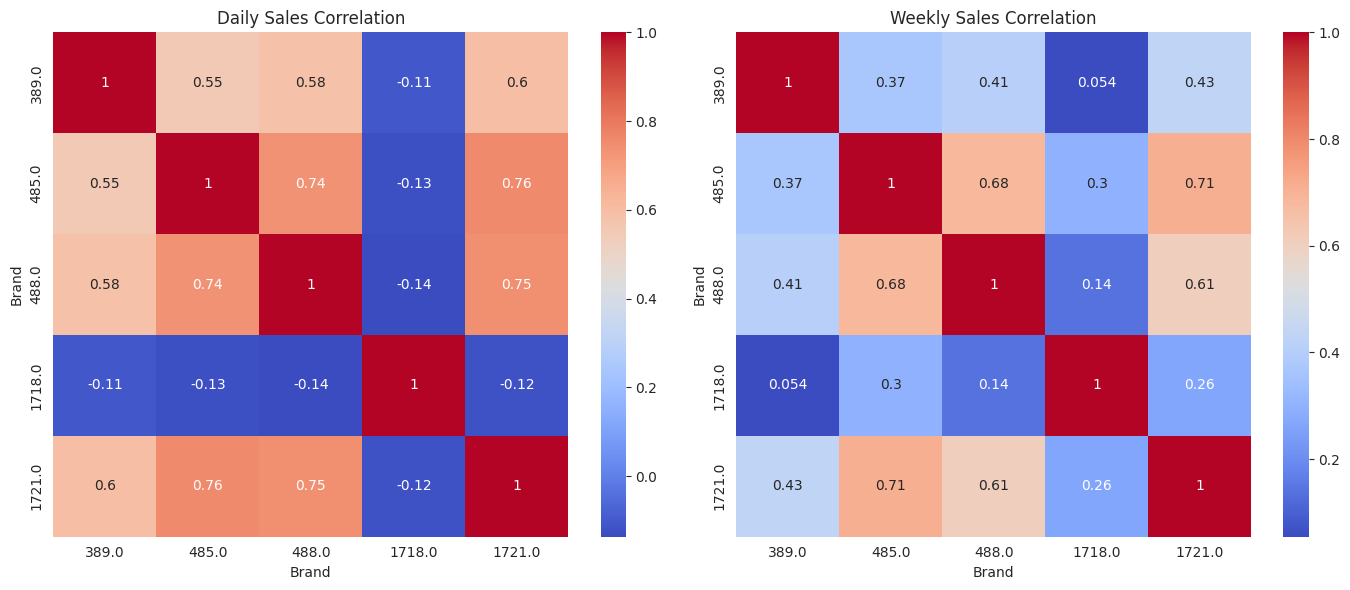

In [43]:
# === Cell 8: Correlation Analysis ===
# 1) Brand-to-brand correlation on raw daily data
corr_daily = ts.corr()

# 2) On weekly aggregated data
corr_weekly = weekly.corr()

# Plot heatmaps
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(corr_daily, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Daily Sales Correlation')
sns.heatmap(corr_weekly, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Weekly Sales Correlation')
plt.tight_layout()
plt.show()


Cross correlation functions

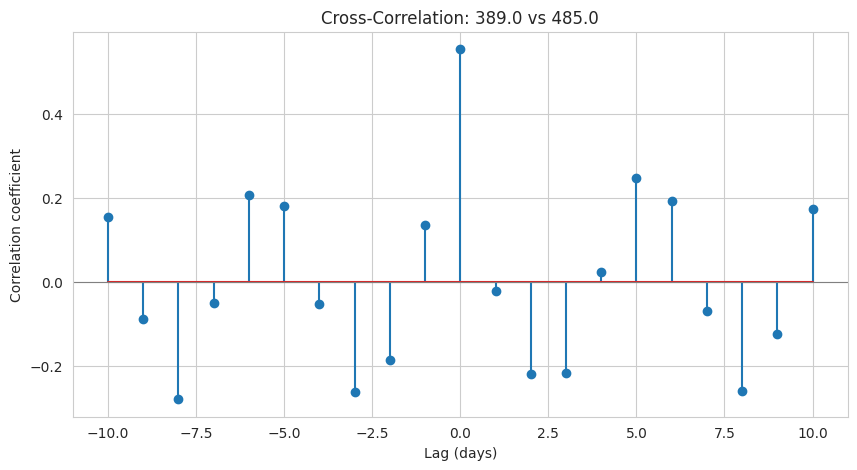

In [45]:
# === Cell 9: Cross-Correlation Functions (CCF) ===
from statsmodels.tsa.stattools import ccf

brands = ts.columns.tolist()
if len(brands) < 2:
    print("Need at least two brands to compute a cross-correlation.")
else:
    b1, b2 = brands[0], brands[1]
    # define lags (negative = b2 leads, positive = b1 leads)
    lags = np.arange(-10, 11)
    xcorrs = [ts[b1].corr(ts[b2].shift(lag)) for lag in lags]

    plt.figure(figsize=(10,5))
    plt.stem(lags, xcorrs)   # no use_line_collection argument
    plt.title(f'Cross-Correlation: {b1} vs {b2}')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation coefficient')
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.show()

Seasonal decompositions

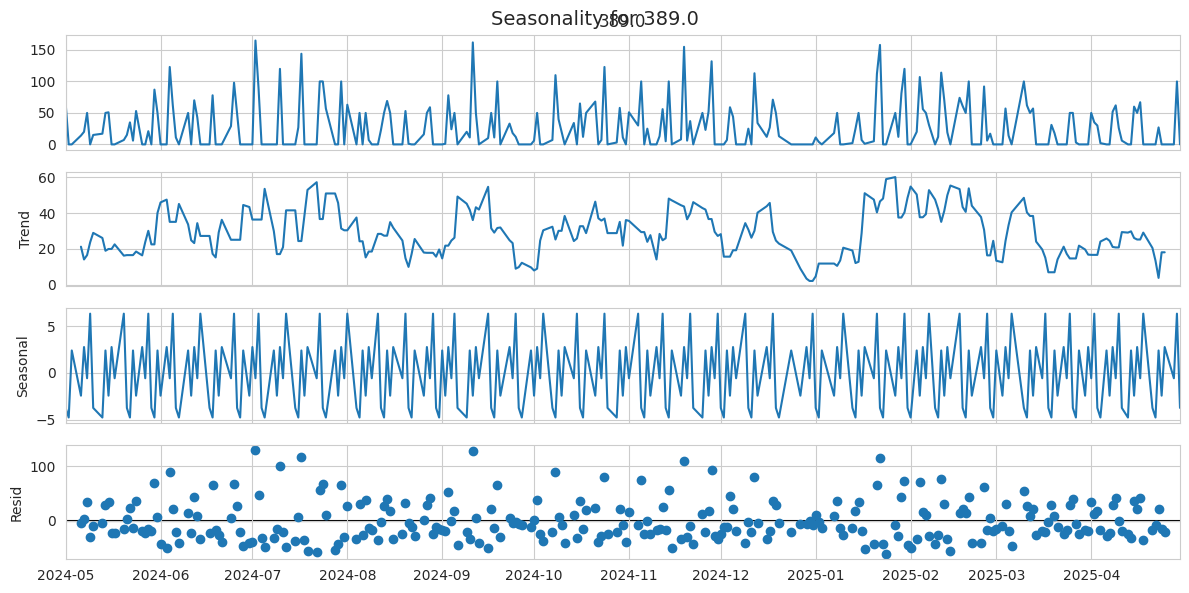

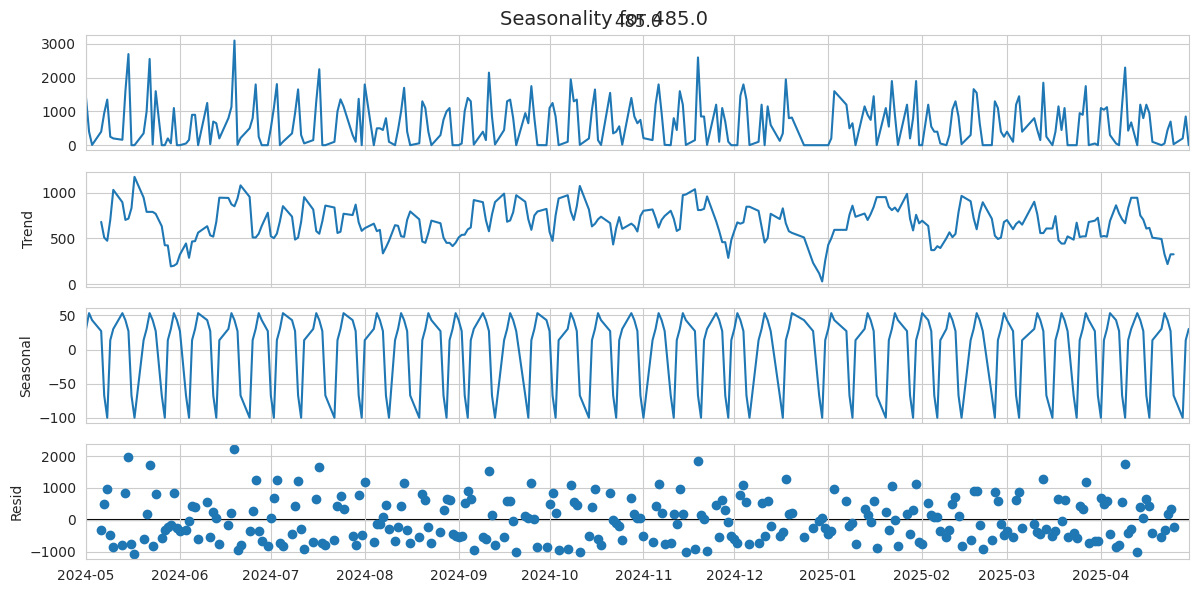

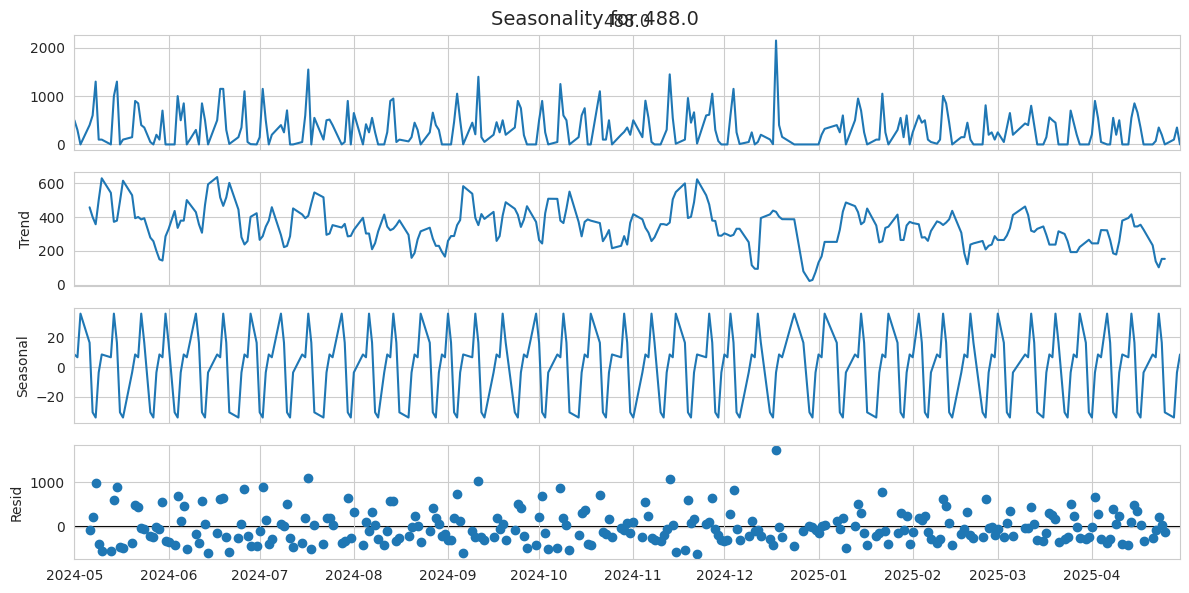

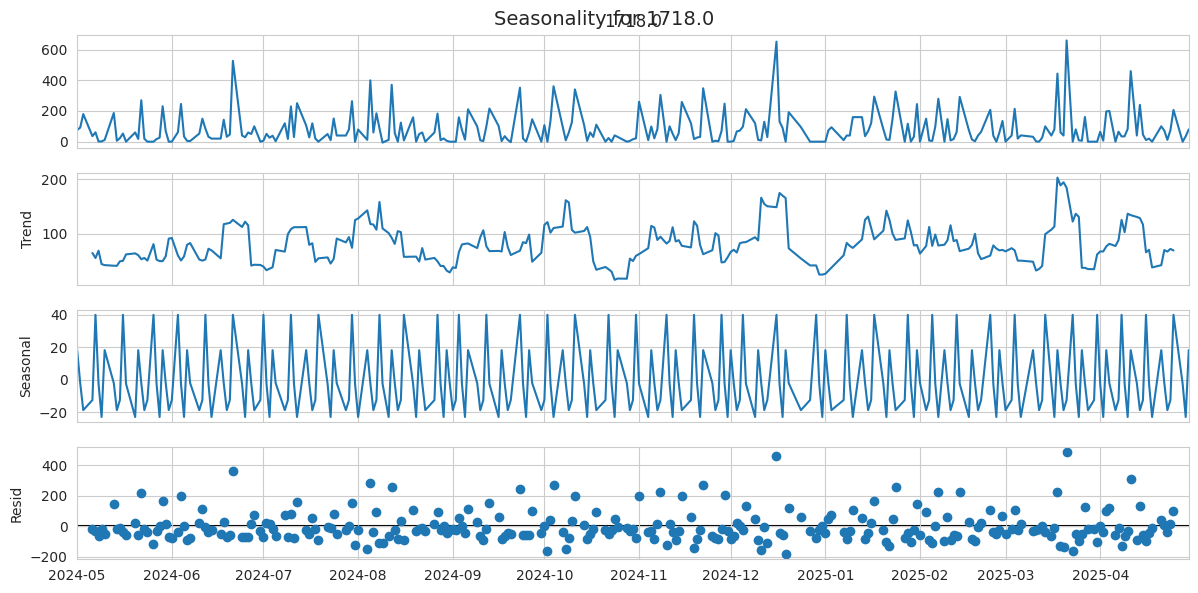

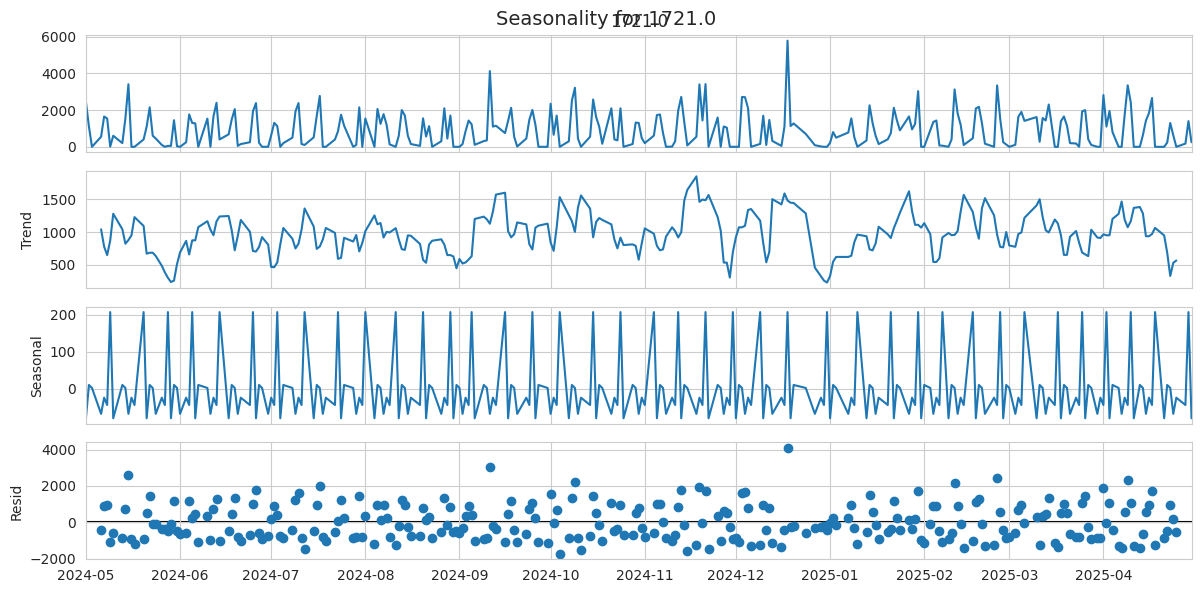

In [46]:
# === Cell 10: Seasonal Decomposition ===
for brand in ts.columns:
    try:
        result = seasonal_decompose(ts[brand], model='additive', period=7)
        result.plot().suptitle(f'Seasonality for {brand}', fontsize=14)
        plt.show()
    except Exception as e:
        print(f"Could not decompose {brand}: {e}")


Installing client for intelligent analysis

In [52]:
# === Cell 11 (revised): Install & Configure the NEW SDK ===
# uninstall the old, deprecated library and install the new one
!pip uninstall -y google-generativeai
!pip install --quiet google-genai

from google import genai
import json

# load your Gemini key from Drive
key_path = '/content/drive/MyDrive/sales/gemini_credentials.json'
with open(key_path, 'r') as f:
    creds = json.load(f)
api_key = creds.get('api_key')
if not api_key:
    raise RuntimeError("No 'api_key' field found in your credentials file.")

# create a GenAI client
client = genai.Client(api_key=api_key)
print("✅ GenAI Client created")


Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
✅ GenAI Client created


Building metrics and generating summary

In [67]:
# === Cell 12 (revised): Build Metrics Text & Generate Summary ===

def generate_summary_via_gemini(prompt: str) -> str:
    """
    Send a simple prompt to Gemini and return the generated text.
    Uses the non-chat 'generate_content' endpoint.
    """
    try:
        resp = client.models.generate_content(
            model="gemini-2.0-flash-001",    # or your available Gemini model
            contents=prompt
        )
        return resp.text
    except Exception as e:
        return f"⚠️ API error: {e}"

# 1) Assemble your statistics as text
payload = "\n\n".join([
    "Daily Sales Descriptive Statistics:\n" + ts.describe().to_string(),
    "Weekly Sales Descriptive Statistics:\n" + weekly.describe().to_string(),
    "Weekly Brand Correlations:\n"        + corr_weekly.to_string()
])

# 2) Prepend an instruction
full_prompt = (
    "You are an expert financial data analyst and your job is to look for patterns. "
    "Summarize the given data including the source file, and show me which weeks, in format of first, second, third, fourth week - have the highest sales. and have the lowest sales "
    "in the following dataset metrics:\n\n" + payload
)

# 3) Ask Gemini and print
print("=== Automated Summary ===\n")
print(generate_summary_via_gemini(full_prompt))


=== Automated Summary ===

Okay, let's break down this sales data and identify high and low sales weeks for each brand.

**Data Summary**

*   **Source:** The data appears to be derived from daily sales information aggregated into weekly sales figures.
*   **Metrics:** The primary metric is sales for each of the five brands: 389.0, 485.0, 488.0, 1718.0, and 1721.0.
*   **Time Period:** The weekly data covers 53 weeks (presumably a little over a year's worth of data), as indicated by the count in the "Weekly Sales Descriptive Statistics."
*   **Descriptive Statistics:** We have descriptive statistics for both daily and weekly sales. These statistics include:
    *   `count`: Number of data points
    *   `mean`: Average sales
    *   `std`: Standard deviation (a measure of variability)
    *   `min`: Minimum sales value
    *   `25%`: First quartile (25th percentile)
    *   `50%`: Second quartile or median (50th percentile)
    *   `75%`: Third quartile (75th percentile)
    *   `max`:

Exporting data to Excel

In [66]:
# === Cell 13: Export Graphs and Summary to Excel ===

# 1) Verify prerequisites
try:
    ts, weekly, monthly, full_prompt, generate_summary_via_gemini
except NameError:
    raise RuntimeError(
        "You need to run Cells 5 (ts), 7 (weekly & monthly), and 12 (generate_summary_via_gemini) first."
    )

# 2) Install writer
!pip install --quiet xlsxwriter

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 3) Prepare temp folder and output path
img_dir = 'temp_images'
os.makedirs(img_dir, exist_ok=True)
# In Colab use:
# output_path = '/content/drive/MyDrive/sales/sales_report.xlsx'
# Or local:
output_path = 'sales_report.xlsx'

# Helper: save a figure to disk and close it
def save_fig(fig, name):
    path = os.path.join(img_dir, name)
    fig.savefig(path, bbox_inches='tight')
    plt.close(fig)
    return path

# 4) Generate all plots
plots = []

# Daily Sales
fig, ax = plt.subplots()
ts.plot(ax=ax)
ax.set_title('Daily Sales by Brand')
ax.set_ylabel('Units Sold')
ax.set_xlabel('Date')
plots.append(('Daily_Sales', fig))

# Weekly Sales
fig, ax = plt.subplots()
weekly.plot(ax=ax)
ax.set_title('Weekly Sales by Brand')
ax.set_ylabel('Units per Week')
ax.set_xlabel('Date')
plots.append(('Weekly_Sales', fig))

# Monthly Sales
fig, ax = plt.subplots()
monthly.plot(ax=ax)
ax.set_title('Monthly Sales by Brand')
ax.set_ylabel('Units per Month')
ax.set_xlabel('Date')
plots.append(('Monthly_Sales', fig))

# Daily Correlation
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(ts.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Daily Sales Correlation')
plots.append(('Corr_Daily', fig))

# Weekly Correlation
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(weekly.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Weekly Sales Correlation')
plots.append(('Corr_Weekly', fig))

# Cross-Correlation (first two brands)
b1, b2 = ts.columns[:2]
lags = np.arange(-10, 11)
xc = [ts[b1].corr(ts[b2].shift(lag)) for lag in lags]
fig, ax = plt.subplots()
ax.stem(lags, xc)
ax.set_title(f'Cross-Correlation: {b1} vs {b2}')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation coefficient')
plots.append((f'CrossCorr_{b1}_{b2}', fig))

# Seasonality decomposition
for brand in ts.columns:
    result = seasonal_decompose(ts[brand], model='additive', period=7)
    fig = result.plot()
    fig.suptitle(f'Seasonality: {brand}')
    plots.append((f'Decomp_{brand}', fig))

# 5) Write to Excel
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    # Summary sheet
    summary_text = generate_summary_via_gemini(full_prompt)
    pd.DataFrame({'Summary': summary_text.split('\n')}) \
      .to_excel(writer, sheet_name='Summary', index=False)
    workbook = writer.book

    # One sheet per plot
    for name, fig in plots:
        img_path = save_fig(fig, f'{name}.png')
        sheet = name[:31]  # Excel limit
        worksheet = workbook.add_worksheet(sheet)
        worksheet.insert_image('B2', img_path)

print(f"✅ Report saved to {output_path}")


✅ Report saved to sales_report.xlsx
